# Network Visualizations - Helsinki City Bikes

This notebook contains interactive visualizations and network analysis for the Helsinki City Bikes system.

In [1]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Load Data

In [2]:
# Load merged data with coordinates
df = pd.read_csv('../data/2021-04_merged.csv')

# Convert date columns to datetime
df['Departure'] = pd.to_datetime(df['Departure'])
df['Return'] = pd.to_datetime(df['Return'])

# Add time features
df['hour'] = df['Departure'].dt.hour
df['day_of_week'] = df['Departure'].dt.dayofweek
df['day_name'] = df['Departure'].dt.day_name()
df['date'] = df['Departure'].dt.date

print(f"Total trips: {len(df):,}")
print(f"Date range: {df['Departure'].min()} to {df['Departure'].max()}")
print(f"Unique stations (departure): {df['Departure station id'].nunique()}")
print(f"Unique stations (return): {df['Return station id'].nunique()}")
df.head()

Total trips: 258,514
Date range: 2021-04-01 06:06:02 to 2021-04-30 23:59:54
Unique stations (departure): 351
Unique stations (return): 351


,Departure,Return,Departure station id,Departure station name,Return station id,Return station name,Covered distance (m),Duration (sec.),new_duration,departure_lat,departure_lon,return_lat,return_lon,hour,day_of_week,day_name,date
0,2021-04-30 23:59:54,2021-05-01 00:08:15,16,Liisanpuistikko,2,Laivasillankatu,1885.0,499,501,60.173821,24.960528,60.161155,24.956137,23,4,Friday,2021-04-30
1,2021-04-30 23:59:52,2021-05-01 00:13:40,4,Viiskulma,33,Kauppakorkeakoulu,1633.0,824,828,60.160788,24.941989,60.171179,24.925009,23,4,Friday,2021-04-30
2,2021-04-30 23:59:52,2021-05-01 00:16:16,20,Kaisaniemenpuisto,112,Rautatieläisenkatu,3359.0,984,984,60.174997,24.946092,60.201718,24.939750,23,4,Friday,2021-04-30
3,2021-04-30 23:59:43,2021-05-01 00:23:22,133,Paavalinpuisto,241,Agronominkatu,6459.0,1418,1419,60.197039,24.960999,60.234627,25.033847,23,4,Friday,2021-04-30
4,2021-04-30 23:59:41,2021-05-01 00:16:15,20,Kaisaniemenpuisto,112,Rautatieläisenkatu,3210.0,990,994,60.174997,24.946092,60.201718,24.939750,23,4,Friday,2021-04-30


## 1. Enhanced Bubble Map with Heatmap Layer

In [3]:
def mapPlot(dataframe, year=2021, month=None, station_type='departure', add_heatmap=True):
    """
    Creates an interactive bubble plot with optional heatmap layer.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        Merged dataframe with trip and coordinate data
    year : int
        Year to filter data (default: 2021)
    month : int, optional
        Month to filter data (default: None - all months)
    station_type : str
        'departure' or 'return' - which station to visualize (default: 'departure')
    add_heatmap : bool
        Whether to add heatmap layer (default: True)
    """
    # Copy and filter data
    df_plot = dataframe.copy()
    df_plot = df_plot[df_plot['Departure'].dt.year == year]
    
    if month is not None:
        df_plot = df_plot[df_plot['Departure'].dt.month == month]
    
    # Set column names based on station type
    if station_type == 'departure':
        station_id_col = 'Departure station id'
        station_name_col = 'Departure station name'
        lat_col = 'departure_lat'
        lon_col = 'departure_lon'
        color = '#3498db'  # Blue for departures
    else:
        station_id_col = 'Return station id'
        station_name_col = 'Return station name'
        lat_col = 'return_lat'
        lon_col = 'return_lon'
        color = '#e74c3c'  # Red for returns
    
    # Calculate frequency per station
    df_plot['freq'] = df_plot.groupby(station_id_col)[station_id_col].transform('count')
    
    # Create unique station dataframe
    df_stations = df_plot[[station_id_col, station_name_col, lat_col, lon_col, 'freq']].drop_duplicates(
        subset=[station_id_col]
    )
    df_stations = df_stations.dropna()
    
    # Adjust bubble size (normalize by median)
    median_freq = df_stations['freq'].median()
    df_stations['freq_adj'] = df_stations['freq'] / (median_freq / 3)
    
    print(f"Visualizing {len(df_stations)} stations")
    print(f"Total trips: {len(df_plot):,}")
    print(f"Frequency range: {df_stations['freq'].min()} - {df_stations['freq'].max()}")
    
    # Create map centered on Helsinki
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)
    
    # Add heatmap layer if requested
    if add_heatmap:
        heat_data = [[row[lat_col], row[lon_col], row['freq']] for _, row in df_stations.iterrows()]
        plugins.HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(hel_map)
    
    # Add circle markers for each station
    for index, row in df_stations.iterrows():
        folium.CircleMarker(
            [row[lat_col], row[lon_col]],
            radius=row['freq_adj'],
            popup=f"<b>{row[station_name_col]}</b><br>ID: {int(row[station_id_col])}<br>Trips: {int(row['freq']):,}",
            tooltip=f"{row[station_name_col]} ({int(row['freq'])} trips)",
            color=color,
            fill_color=color,
            fill_opacity=0.7,
            weight=2
        ).add_to(hel_map)
    
    # Add layer control
    folium.LayerControl().add_to(hel_map)
    
    return hel_map

In [4]:
# Create and display enhanced map for departure stations
departure_map = mapPlot(df, year=2021, month=4, station_type='departure', add_heatmap=True)
display(departure_map)

Visualizing 351 stations
Total trips: 258,514
Frequency range: 16 - 4799


## 2. Route Flow Visualization

Visualize the most popular routes with arrows showing direction and flow.

In [5]:
def routeFlowMap(dataframe, top_n=50, min_trips=100):
    """
    Creates a map showing the most popular routes between stations.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        Merged dataframe with trip and coordinate data
    top_n : int
        Number of top routes to display (default: 50)
    min_trips : int
        Minimum number of trips for a route to be displayed (default: 100)
    """
    # Calculate route frequencies
    routes = dataframe.groupby([
        'Departure station id', 'Departure station name', 'departure_lat', 'departure_lon',
        'Return station id', 'Return station name', 'return_lat', 'return_lon'
    ]).size().reset_index(name='trips')
    
    # Filter and get top routes
    routes = routes[routes['trips'] >= min_trips]
    routes = routes.nlargest(top_n, 'trips')
    
    print(f"Showing top {len(routes)} routes (min {min_trips} trips)")
    print(f"Route frequency range: {routes['trips'].min()} - {routes['trips'].max()}")
    
    # Create map
    route_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(route_map)
    
    # Normalize line weights
    max_trips = routes['trips'].max()
    min_trips_val = routes['trips'].min()
    
    # Add routes as lines
    for _, route in routes.iterrows():
        # Skip same station routes
        if route['Departure station id'] == route['Return station id']:
            continue
        
        # Normalize weight (1-10)
        weight = 1 + 9 * (route['trips'] - min_trips_val) / (max_trips - min_trips_val)
        
        # Calculate color based on frequency (blue to red gradient)
        intensity = (route['trips'] - min_trips_val) / (max_trips - min_trips_val)
        color = plt.cm.YlOrRd(intensity)
        color_hex = '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))
        
        # Create line
        points = [
            [route['departure_lat'], route['departure_lon']],
            [route['return_lat'], route['return_lon']]
        ]
        
        folium.PolyLine(
            points,
            color=color_hex,
            weight=weight,
            opacity=0.7,
            popup=f"<b>{route['Departure station name']}</b> → <b>{route['Return station name']}</b><br>Trips: {int(route['trips']):,}",
            tooltip=f"{route['Departure station name']} → {route['Return station name']} ({int(route['trips'])} trips)"
        ).add_to(route_map)
        
        # Add arrow in the middle
        mid_lat = (route['departure_lat'] + route['return_lat']) / 2
        mid_lon = (route['departure_lon'] + route['return_lon']) / 2
        
        plugins.BeautifyIcon(
            icon='arrow-right',
            border_color=color_hex,
            text_color=color_hex,
            icon_shape='marker'
        )
    
    return route_map

In [6]:
# Create and display route flow map
flow_map = routeFlowMap(df, top_n=30, min_trips=150)
display(flow_map)

Showing top 30 routes (min 150 trips)
Route frequency range: 161 - 1113


## 3. Temporal Analysis - Hourly Patterns

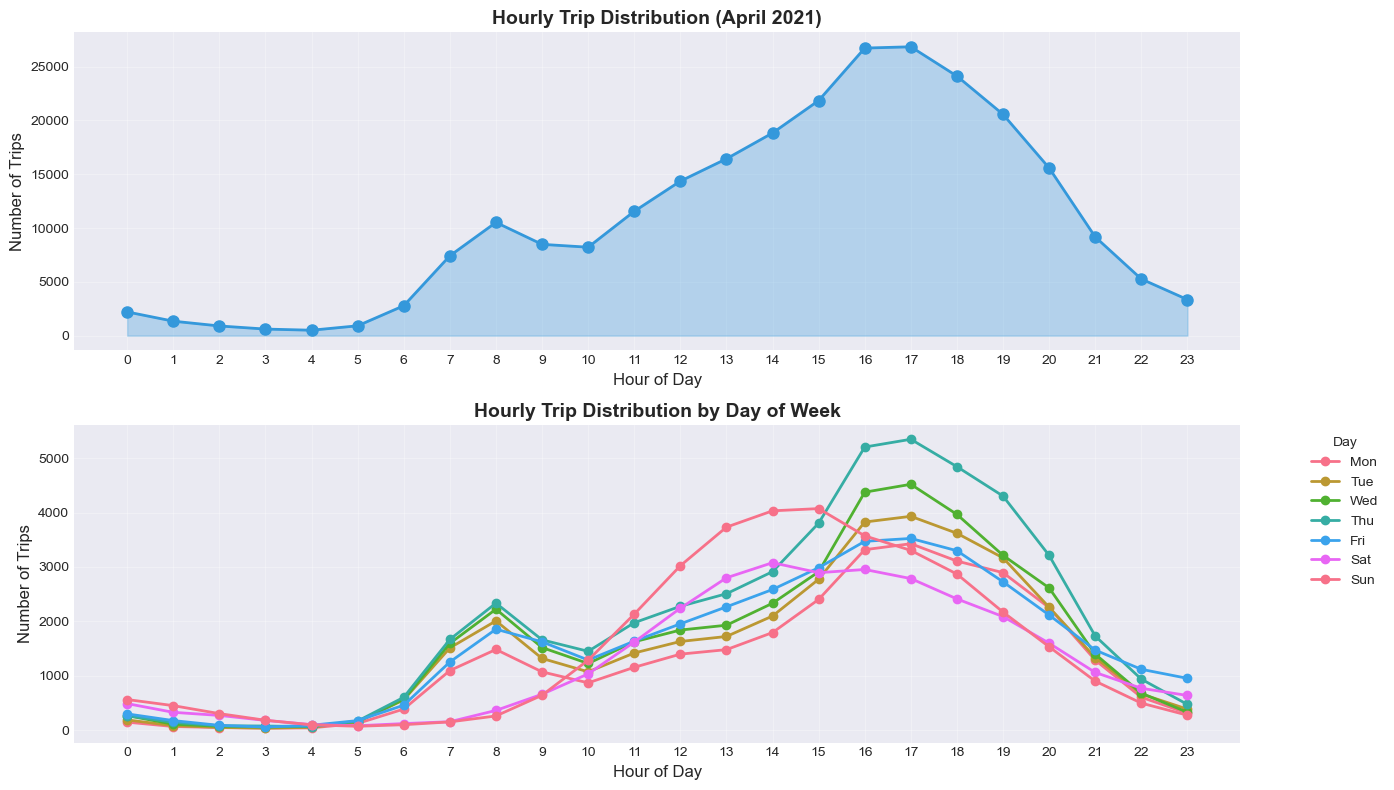

In [7]:
# Hourly trip distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Overall hourly pattern
hourly_trips = df.groupby('hour').size()
axes[0].plot(hourly_trips.index, hourly_trips.values, marker='o', linewidth=2, markersize=8, color='#3498db')
axes[0].fill_between(hourly_trips.index, hourly_trips.values, alpha=0.3, color='#3498db')
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Number of Trips', fontsize=12)
axes[0].set_title('Hourly Trip Distribution (April 2021)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))

# Hourly pattern by day of week
hourly_weekday = df.groupby(['day_of_week', 'hour']).size().reset_index(name='trips')
pivot_hourly = hourly_weekday.pivot(index='hour', columns='day_of_week', values='trips')
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_hourly.columns = [day_names[i] for i in pivot_hourly.columns]

pivot_hourly.plot(ax=axes[1], marker='o', linewidth=2, markersize=6)
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Number of Trips', fontsize=12)
axes[1].set_title('Hourly Trip Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24))
axes[1].legend(title='Day', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 4. Station Imbalance Analysis

Identify stations with imbalanced inflow/outflow.

In [8]:
# Calculate departures and arrivals per station
departures = df.groupby(['Departure station id', 'Departure station name', 'departure_lat', 'departure_lon']).size().reset_index(name='departures')
arrivals = df.groupby(['Return station id', 'Return station name', 'return_lat', 'return_lon']).size().reset_index(name='arrivals')

# Merge
station_balance = departures.merge(
    arrivals,
    left_on='Departure station id',
    right_on='Return station id',
    how='outer'
).fillna(0)

# Calculate balance
station_balance['net_flow'] = station_balance['departures'] - station_balance['arrivals']
station_balance['total_trips'] = station_balance['departures'] + station_balance['arrivals']
station_balance['balance_ratio'] = station_balance['net_flow'] / station_balance['total_trips']

# Use departure station info for coordinates
station_balance['station_name'] = station_balance['Departure station name'].fillna(station_balance['Return station name'])
station_balance['lat'] = station_balance['departure_lat'].fillna(station_balance['return_lat'])
station_balance['lon'] = station_balance['departure_lon'].fillna(station_balance['return_lon'])

print("Top 10 stations with most departures (potential bike deficit):")
print(station_balance.nlargest(10, 'net_flow')[['station_name', 'departures', 'arrivals', 'net_flow']].to_string(index=False))

print("\nTop 10 stations with most arrivals (potential bike surplus):")
print(station_balance.nsmallest(10, 'net_flow')[['station_name', 'departures', 'arrivals', 'net_flow']].to_string(index=False))

Top 10 stations with most departures (potential bike deficit):
     station_name  departures  arrivals  net_flow
    Pasilan asema        3684      3136       548
Workshop Helsinki         210         3       207
      Mäkelänkatu         981       799       182
       Linnanmäki        1763      1587       176
   Hertanmäenkatu         666       509       157
      Karhupuisto         934       780       154
      Kustaankatu        1008       861       147
 Vallilan varikko         572       439       133
    Venttiilikuja        1089       967       122
      Töölöntulli        1600      1480       120

Top 10 stations with most arrivals (potential bike surplus):
         station_name  departures  arrivals  net_flow
       Kalasatama (M)        3529      3894      -365
          Unioninkatu        1000      1314      -314
   Leppävaarankäytävä         722       984      -262
           Ympyrätalo        3330      3560      -230
     Töölönlahdenkatu        2689      2917      -228
 

In [9]:
# Visualize station balance on map
def balanceMap(station_balance_df):
    """
    Creates a map showing station balance (red = more departures, blue = more arrivals).
    """
    balance_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(balance_map)
    
    # Normalize for visualization
    max_abs_balance = abs(station_balance_df['net_flow']).max()
    
    for _, station in station_balance_df.iterrows():
        if pd.isna(station['lat']) or pd.isna(station['lon']):
            continue
        
        balance_ratio = station['net_flow'] / max_abs_balance
        
        # Color: blue (more arrivals) to red (more departures)
        if balance_ratio > 0:
            color = '#e74c3c'  # Red for more departures
        else:
            color = '#3498db'  # Blue for more arrivals
        
        # Size based on total activity
        radius = 5 + 15 * (station['total_trips'] / station_balance_df['total_trips'].max())
        
        folium.CircleMarker(
            [station['lat'], station['lon']],
            radius=radius,
            popup=f"<b>{station['station_name']}</b><br>"
                  f"Departures: {int(station['departures']):,}<br>"
                  f"Arrivals: {int(station['arrivals']):,}<br>"
                  f"Net Flow: {int(station['net_flow']):+,}",
            tooltip=f"{station['station_name']} (Net: {int(station['net_flow']):+})",
            color=color,
            fill_color=color,
            fill_opacity=0.7,
            weight=2
        ).add_to(balance_map)
    
    return balance_map

balance_viz = balanceMap(station_balance)
display(balance_viz)

## 5. Trip Distance and Duration Analysis

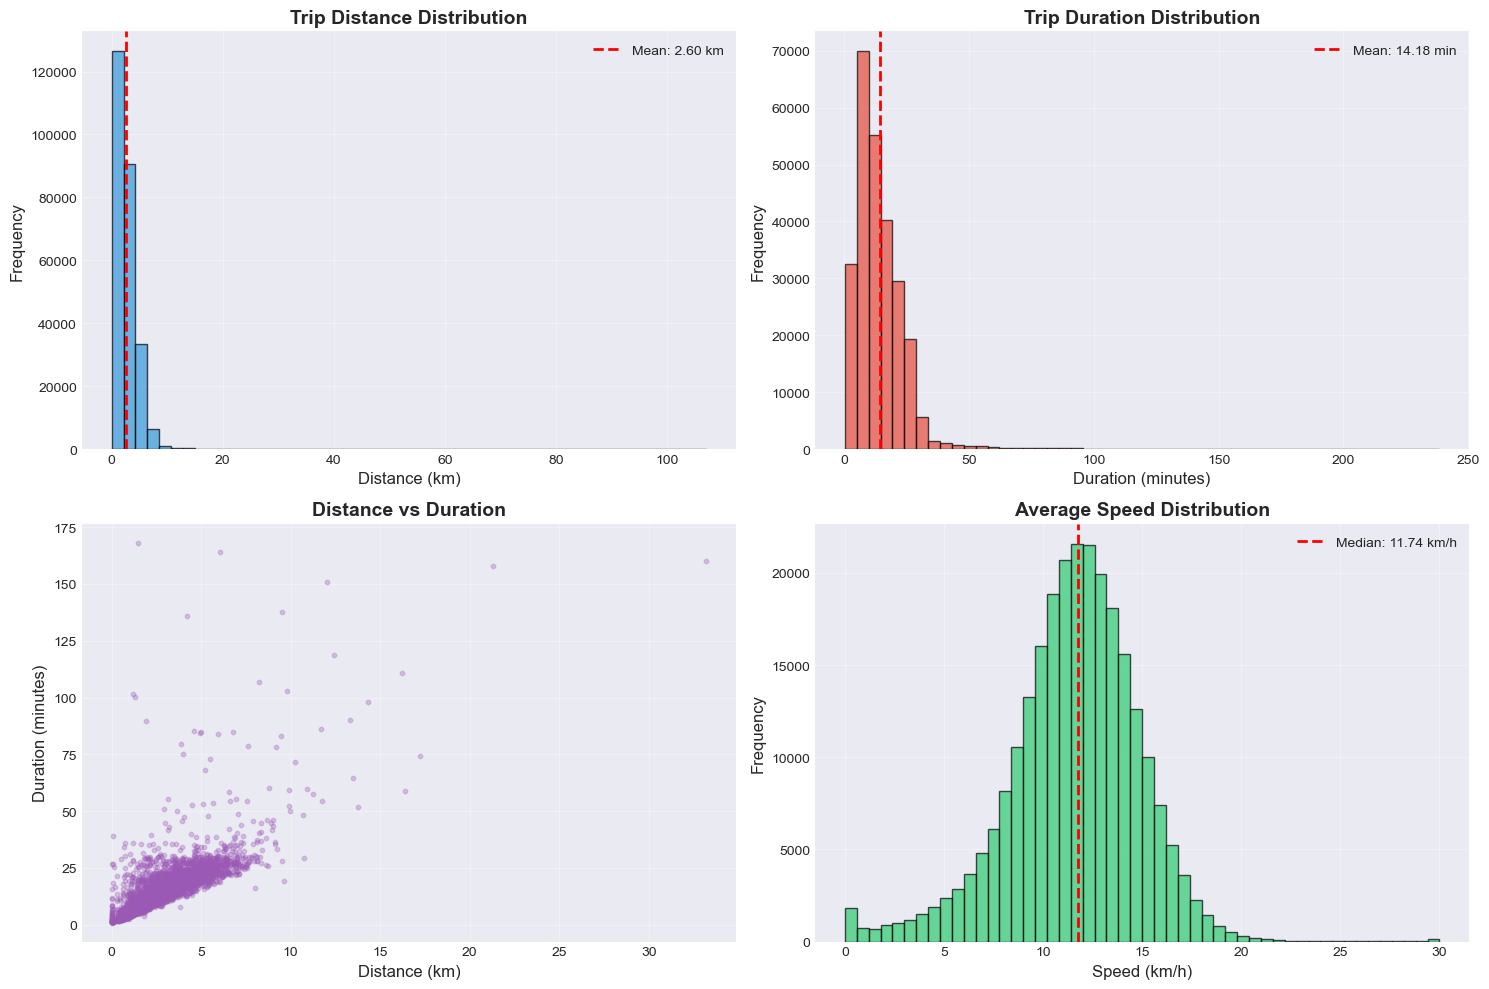


Trip Statistics:
Mean distance: 2.60 km
Mean duration: 14.18 minutes
Median speed: 11.74 km/h


In [10]:
# Distance and duration statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distance distribution
axes[0, 0].hist(df['Covered distance (m)'] / 1000, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Distance (km)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Trip Distance Distribution', fontsize=14, fontweight='bold')
axes[0, 0].axvline(df['Covered distance (m)'].mean() / 1000, color='red', linestyle='--', linewidth=2, label=f"Mean: {df['Covered distance (m)'].mean()/1000:.2f} km")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Duration distribution
axes[0, 1].hist(df['Duration (sec.)'] / 60, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Duration (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Trip Duration Distribution', fontsize=14, fontweight='bold')
axes[0, 1].axvline(df['Duration (sec.)'].mean() / 60, color='red', linestyle='--', linewidth=2, label=f"Mean: {df['Duration (sec.)'].mean()/60:.2f} min")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distance vs Duration scatter
sample = df.sample(min(5000, len(df)))  # Sample for performance
axes[1, 0].scatter(sample['Covered distance (m)'] / 1000, sample['Duration (sec.)'] / 60, 
                   alpha=0.3, s=10, color='#9b59b6')
axes[1, 0].set_xlabel('Distance (km)', fontsize=12)
axes[1, 0].set_ylabel('Duration (minutes)', fontsize=12)
axes[1, 0].set_title('Distance vs Duration', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Average speed distribution
df['speed_kmh'] = (df['Covered distance (m)'] / 1000) / (df['Duration (sec.)'] / 3600)
axes[1, 1].hist(df['speed_kmh'].clip(0, 30), bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Speed (km/h)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Average Speed Distribution', fontsize=14, fontweight='bold')
axes[1, 1].axvline(df['speed_kmh'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {df['speed_kmh'].median():.2f} km/h")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTrip Statistics:")
print(f"Mean distance: {df['Covered distance (m)'].mean()/1000:.2f} km")
print(f"Mean duration: {df['Duration (sec.)'].mean()/60:.2f} minutes")
print(f"Median speed: {df['speed_kmh'].median():.2f} km/h")

## 6. Daily Trend Analysis

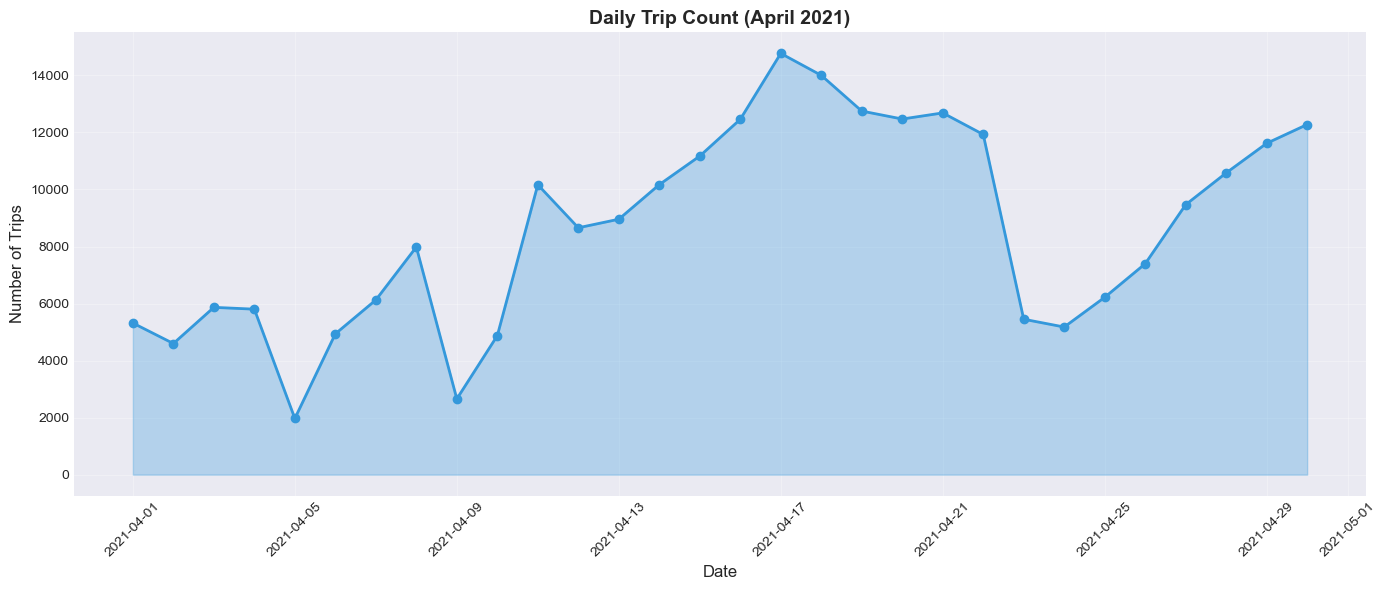

Busiest day: 2021-04-17 00:00:00 with 14,772 trips
Quietest day: 2021-04-05 00:00:00 with 1,970 trips


In [11]:
# Daily trip counts
daily_trips = df.groupby('date').size().reset_index(name='trips')
daily_trips['date'] = pd.to_datetime(daily_trips['date'])

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_trips['date'], daily_trips['trips'], marker='o', linewidth=2, markersize=6, color='#3498db')
ax.fill_between(daily_trips['date'], daily_trips['trips'], alpha=0.3, color='#3498db')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Trips', fontsize=12)
ax.set_title('Daily Trip Count (April 2021)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Busiest day: {daily_trips.loc[daily_trips['trips'].idxmax(), 'date']} with {daily_trips['trips'].max():,} trips")
print(f"Quietest day: {daily_trips.loc[daily_trips['trips'].idxmin(), 'date']} with {daily_trips['trips'].min():,} trips")

## 7. Top Station Pairs (Most Popular Routes)

Top 20 Most Popular Routes:
               Departure station name                   Return station name  trips
Aalto-yliopisto (M), Korkeakouluaukio                         Jämeräntaival   1113
                        Jämeräntaival Aalto-yliopisto (M), Korkeakouluaukio   1064
                      Tyynenmerenkatu                          Itämerentori    334
                         Itämerentori                       Tyynenmerenkatu    319
                      Haukilahdenkatu                        Kalasatama (M)    275
                       Kalasatama (M)                       Lintulahdenkatu    270
                       Kalasatama (M)                       Haukilahdenkatu    269
                      Lintulahdenkatu                        Kalasatama (M)    235
                         Kirjurinkuja                             Ratsutori    219
                            Ratsutori                          Kirjurinkuja    218
                     Länsisatamankuja                      

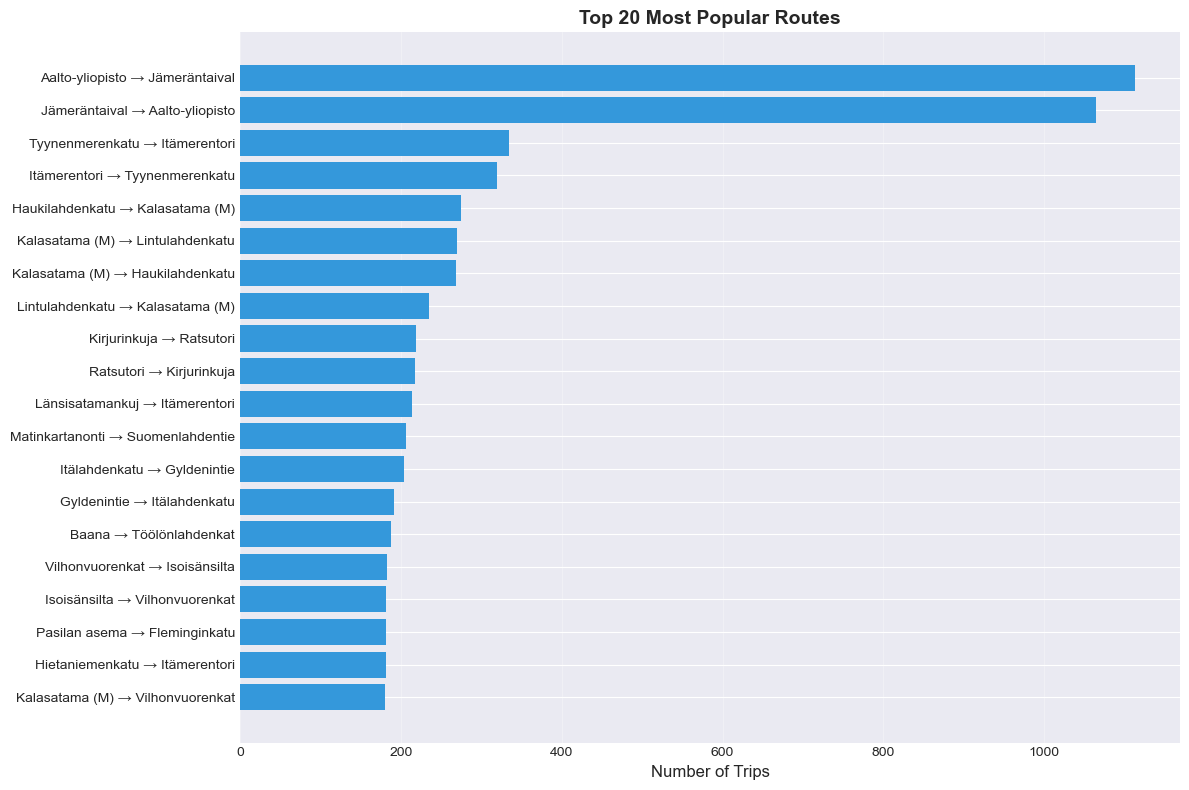

In [12]:
# Most popular routes
routes = df.groupby(['Departure station name', 'Return station name']).size().reset_index(name='trips')
routes = routes[routes['Departure station name'] != routes['Return station name']]  # Exclude same-station trips
routes = routes.sort_values('trips', ascending=False)

print("Top 20 Most Popular Routes:")
print(routes.head(20).to_string(index=False))

# Visualize top 20 routes
fig, ax = plt.subplots(figsize=(12, 8))
top_routes = routes.head(20)
top_routes['route'] = top_routes['Departure station name'].str[:15] + ' → ' + top_routes['Return station name'].str[:15]
ax.barh(range(len(top_routes)), top_routes['trips'], color='#3498db')
ax.set_yticks(range(len(top_routes)))
ax.set_yticklabels(top_routes['route'])
ax.set_xlabel('Number of Trips', fontsize=12)
ax.set_title('Top 20 Most Popular Routes', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()